In [1]:
from libauc.models.densenet import DenseNet121
import torchxrayvision as xrv
import torchvision
import torch
from mychexpert import CheXpert
from mymimic import MIMIC_Dataset
import matplotlib.pyplot as plt

def make_mimic_data():

    imgpath = "/mnt/qb/baumgartner/rawdata/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.0.0/files"
    csvpath = "/mnt/qb/baumgartner/rawdata/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.0.0/mimic-cxr-2.0.0-chexpert.csv.gz"
    metacsvpath = "/mnt/qb/baumgartner/rawdata/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.0.0/mimic-cxr-2.0.0-metadata.csv.gz"
    views = ["PA", "AP"]

    mimic_data = MIMIC_Dataset(
        imgpath=imgpath,
        csvpath=csvpath,
        metacsvpath=metacsvpath,
        views=views,
        unique_patients=True,
        image_size=224, 
        return_path=True,
    )
    
    return mimic_data

def make_chexpert_data():
    
    data_root = "/mnt/qb/baumgartner/rawdata/CheXpert/CheXpert-v1.0-small/"
    LABELS = [
        "Cardiomegaly",
        "Lung Lesion",
        "Edema",
        "Pneumonia",
        "Atelectasis",
        "Pneumothorax",
        "Pleural Effusion",
    ]
    
    chexpert_data = CheXpert(
        csv_path=data_root+'valid.csv',  
        image_root_path=data_root, 
        use_upsampling=False, 
        use_frontal=True, 
        image_size=224, 
        mode='valid', 
        class_index=-1, 
        train_cols=LABELS, 
        verbose=False, 
        shuffle=False, 
        return_path=True
    )
    
    return chexpert_data

mimic_data = make_mimic_data()
chexpert_data = make_chexpert_data()

In [2]:
model_paths = [
    "/mnt/qb/work/baumgartner/djakobs46/replicate-chexpert-resultsaucm_multi_label_pretrained_model123.pth",
    "/mnt/qb/work/baumgartner/djakobs46/replicate-chexpert-resultsaucm_multi_label_pretrained_model125.pth",
    "/mnt/qb/work/baumgartner/djakobs46/replicate-chexpert-resultsaucm_multi_label_pretrained_model127.pth",
    "/mnt/qb/work/baumgartner/djakobs46/replicate-chexpert-resultsaucm_multi_label_pretrained_model129.pth",
    "/mnt/qb/work/baumgartner/djakobs46/replicate-chexpert-resultsaucm_multi_label_pretrained_model131.pth",
    "/mnt/qb/work/baumgartner/djakobs46/replicate-chexpert-resultsaucm_multi_label_pretrained_model133.pth",
]

model = DenseNet121(pretrained=False, last_activation=None, num_classes=7)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model.to(device)
model.load_state_dict(torch.load(model_paths[0], map_location=device))
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (elu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (elu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (elu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (elu

In [3]:
mimic_loader = torch.utils.data.DataLoader(
    mimic_data, batch_size=1, num_workers=0, shuffle=False
)
mimic_iter = iter(mimic_loader)

chexpert_loader = torch.utils.data.DataLoader(
    chexpert_data, batch_size=1, num_workers=0, shuffle=False
)
chexpert_iter = iter(chexpert_loader)

MIMIC torch.Size([1, 3, 224, 224]) tensor(-2.1179) tensor(2.6400)
CheXpert torch.Size([1, 3, 224, 224]) tensor(-2.1179) tensor(2.6400)


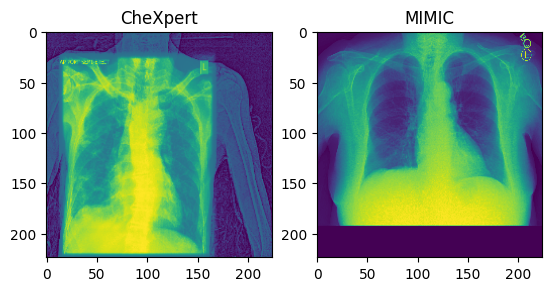

In [9]:
xm, ym, _ = next(mimic_iter)
xc, yc, _ = next(chexpert_iter)

print('MIMIC', xm.shape, xm.min(), xm.max())
print('CheXpert', xc.shape, xc.min(), xc.max())

plt.subplot(121)
plt.imshow(xm.squeeze()[0])
plt.title("MIMIC")
plt.subplot(122)
plt.imshow(xc.squeeze()[0])
plt.title("CheXpert")
plt.show()

In [10]:
xm, xc = xm.cuda(), xc.cuda()

print("MIMIC")
y = model(xm)
print(torch.sigmoid(y))
print(ym)
print("--")
print("Chexpert")
y = model(xc)
print(torch.sigmoid(y))
print(yc)

tensor([[0.3803, 0.8138, 0.2637, 0.6646, 0.1566, 0.4008, 0.1535]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0., 0., 1., 0., 0., 0., 0.]])
--
tensor([[0.0479, 0.6712, 0.0028, 0.3359, 0.0976, 0.0172, 0.0091]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
